## Precomputed SVM

In [2]:
%load_ext autoreload
%autoreload 2

In [87]:
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
X = np.array([[0, 0], [0.5, 0.5], [1, 1], [0.75, 0.75]])
y = [0, 1, 2, 2]
clf = svm.SVC(kernel='precomputed', probability=True)
gram = np.dot(X[:3], X[:3].T)
clf.fit(gram, y[:3])

for x, y in zip(X, y):
    preds = clf.predict_proba(np.dot(x, X[:3].T).reshape(1, -1))[0]
    pred_class = clf.classes_[np.argmin(preds)]
    print('{} -> Expected: {}, Got: {}, Probs: {}'.format(
        ", ".join('{:.2f}'.format(x) for x in x),
        y,
        pred_class,
        ",".join("{:.2f}".format(x) for x in preds))
    )

0.00, 0.00 -> Expected: 0, Got: 0, Probs: 0.24,0.28,0.48
0.50, 0.50 -> Expected: 1, Got: 1, Probs: 0.35,0.30,0.35
1.00, 1.00 -> Expected: 2, Got: 2, Probs: 0.48,0.28,0.24
0.75, 0.75 -> Expected: 2, Got: 2, Probs: 0.41,0.29,0.29


In [164]:
import functools
import wl
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix, vstack

def get_all_nodes(gs):
    return functools.reduce(lambda acc, x: acc | set(x), gs, set())

def get_wl_args(graphs):
    adjs = [nx.adjacency_matrix(g).toarray() for g in graphs]
    nodes = [g.nodes() for g in graphs]
    return adjs, nodes


g1 = nx.DiGraph()
g1.add_edge('A', 'B')
g1.add_edge('B', 'C')

g2 = nx.DiGraph()
g2.add_edge('A', 'B')
g2.add_edge('B', 'C')
g2.add_edge('B', 'D')

g3 = nx.DiGraph()
g3.add_edge('E', 'F')
g3.add_node('G')
all_graphs = (g1, g2, g3)

DEBUG = False
H = 10

all_nodes = get_all_nodes((g1, g2, g3))

adjs, nodes = get_wl_args((g1, g2))
K_1_2, phi_1_2, label_lookups_1_2, label_counters_1_2 = wl.WL_compute(ad_list=adjs, node_label=nodes, all_nodes=all_nodes, h = H, DEBUG=DEBUG)
adjs, nodes = get_wl_args((g1, g2, g3))
K_1_2_3, phi_1_2_3, label_lookups_1_2_3, label_counters_1_2_3 = wl.WL_compute(ad_list=adjs, node_label=nodes, all_nodes=all_nodes, h = H, DEBUG=DEBUG)

TARGET_GRAPH = g3
K_1_2_3_test, phi_1_2_3_test = wl.WL_compute_new(
    ad_list=[nx.adjacency_matrix(TARGET_GRAPH).toarray()],
    node_label=[TARGET_GRAPH.nodes()],
    label_counters_prev = label_counters_1_2,
    all_nodes= all_nodes,
    h = H,
    k_prev = np.copy(K_1_2),
    phi_prev = np.copy(phi_1_2),
    label_lookups_prev = np.copy(label_lookups_1_2)
)

phi_3_test = wl.compute_phi(g3, phi_1_2_3[0].shape, label_lookups_1_2_3, label_counters_1_2_3, h = H)
for idx, (real, new) in enumerate(zip(phi_1_2_3, phi_3_test)):
    real = real[:,2]
    new = lil_matrix(new.reshape(-1,1))
    if not np.array_equiv(real.todense(), new.todense()):
        print('Phi not equal', idx)

if 0 == 1:
    for i, (a, b) in enumerate(zip(phi_1_2_3_test, phi_1_2_3)):
        if not np.array_equiv(a - b.todense(), np.zeros(b.shape, dtype = np.int32)):
            print("\tPhi different! {}".format(i))
            print(np.argwhere((a - b) != 0))

    for i, (a, b) in enumerate(zip(K_1_2_3_test, K_1_2_3)):
        if not np.array_equal(a, b):
            print(np.argwhere((a - b) != 0))
            print("\tK different! {}".format(i))


IndexError: list index out of range

In [161]:
import pickle

with open('data/graphs.npy', 'rb') as f:
    obj = pickle.load(f)
K_train, label_lookup_train, train, label_counters_train, test, phi_list_train = obj['K_train'], obj['label_lookup_train'], obj['train'], obj['label_counters_train'], obj['test'], obj['phi_list_train']

In [163]:
from joblib import Parallel, delayed

from time import time
phi_list_train_last = phi_list_train[-1]
test_graphs = train[:100]

def test_graph(idx, a):
    topic, graph = a
    #if idx % 1 == 0: print('{:>8}/{}'.format(idx, len(test_graphs)))
    phi_train = wl.compute_phi(graph, phi_list_train_last.shape, label_lookup_train, label_counters_train, h = 1)
    for i, (real, new) in enumerate(zip(phi_list_train, phi_train)):
        real = real[:,idx]
        new = lil_matrix(new.reshape(-1,1))
        if not np.array_equiv(real.nonzero()[0], new.nonzero()[0]):
            print('Phi not equal', i, 'Real', real, '\nNew\n', new)
    print('Finished: {}'.format(idx))
    
mats = Parallel(n_jobs=2)(delayed(test_graph)(*d) for d in list(enumerate(test_graphs)))

for idx, (topic, graph) in enumerate(test_graphs):
    break
    if idx % 1 == 0: print('{:>8}/{}'.format(idx, len(test_graphs)))
    phi_train = wl.compute_phi(graph, phi_list_train_last.shape, label_lookup_train, label_counters_train, h = 1)
    for i, (real, new) in enumerate(zip(real_, phi_train)):
        real = real[:,idx]
        new = lil_matrix(new.reshape(-1,1))
        if not np.array_equiv(real.nonzero()[0], new.nonzero()[0]):
            print('Phi not equal', i, 'Real', real, '\nNew\n', new)
            break


Finished: 0
Finished: 1
Finished: 2
Finished: 3
Finished: 4
Finished: 5
Finished: 6
Finished: 7
Finished: 8
Finished: 9
Finished: 11
Finished: 10
Finished: 12
Finished: 13
Finished: 14
Finished: 15
Finished: 16
Finished: 17
Finished: 18
Finished: 19
Finished: 21
Finished: 20
Finished: 22
Finished: 23
Finished: 25
Finished: 24
Finished: 26
Finished: 27


KeyboardInterrupt: 

1.0 -0.5


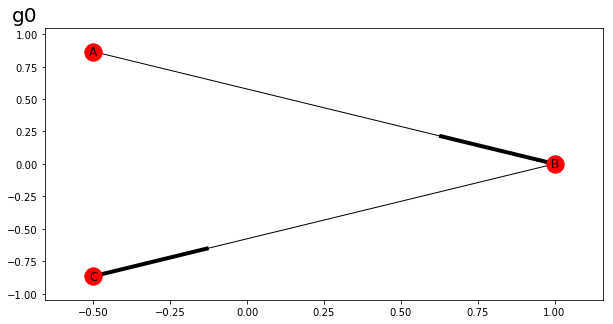

1.0 -1.0


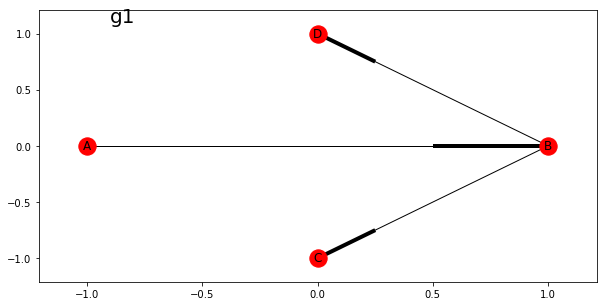

1.0 -0.5


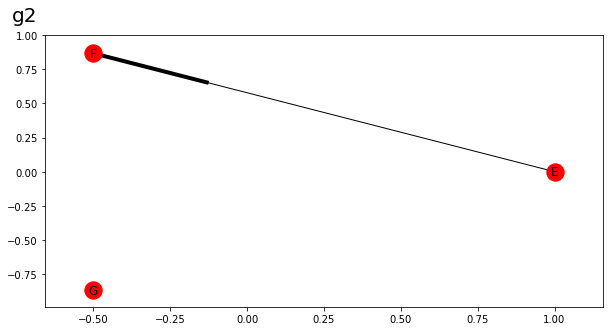

In [5]:
FIG_SIZE = (10, 5)

for idx, graph in enumerate(all_graphs):
    plt.figure(figsize = FIG_SIZE)
    pos = nx.circular_layout(graph)
    nx.draw_networkx(graph, pos = pos)
    
    vals = pos.values()
    y_max = max(x[0] for x in vals)
    y_min = min(x[0] for x in vals)
    x_max = max(x[1] for x in vals)
    x_min = min(x[1] for x in vals)
    plt.text(x = x_min + 0.1, y = y_max + 0.1, s = 'g' + str(idx), fontsize = 20)
    print(y_max, y_min)
    plt.show()

In [61]:
%%time
import dataset_helper

NUM_CLASSES = 8
X, Y = dataset_helper.get_dataset_subset_with_most_frequent_classes('reuters-21578', num_classes_to_keep=NUM_CLASSES)
classes = set(Y)
assert(len(classes) == NUM_CLASSES), 'Not the same class count'
assert(len(X) == len(Y))

CPU times: user 34.9 ms, sys: 8.5 ms, total: 43.4 ms
Wall time: 42.4 ms


In [68]:
X, Y = dataset_helper.get_dataset('r8')
print(set(Y))
assert(len(set(Y)) == 8)
print(len(X), len(Y))

{'ship', 'grain', 'trade', 'interest', 'money-fx', 'acq', 'earn', 'crude'}
9459 9459


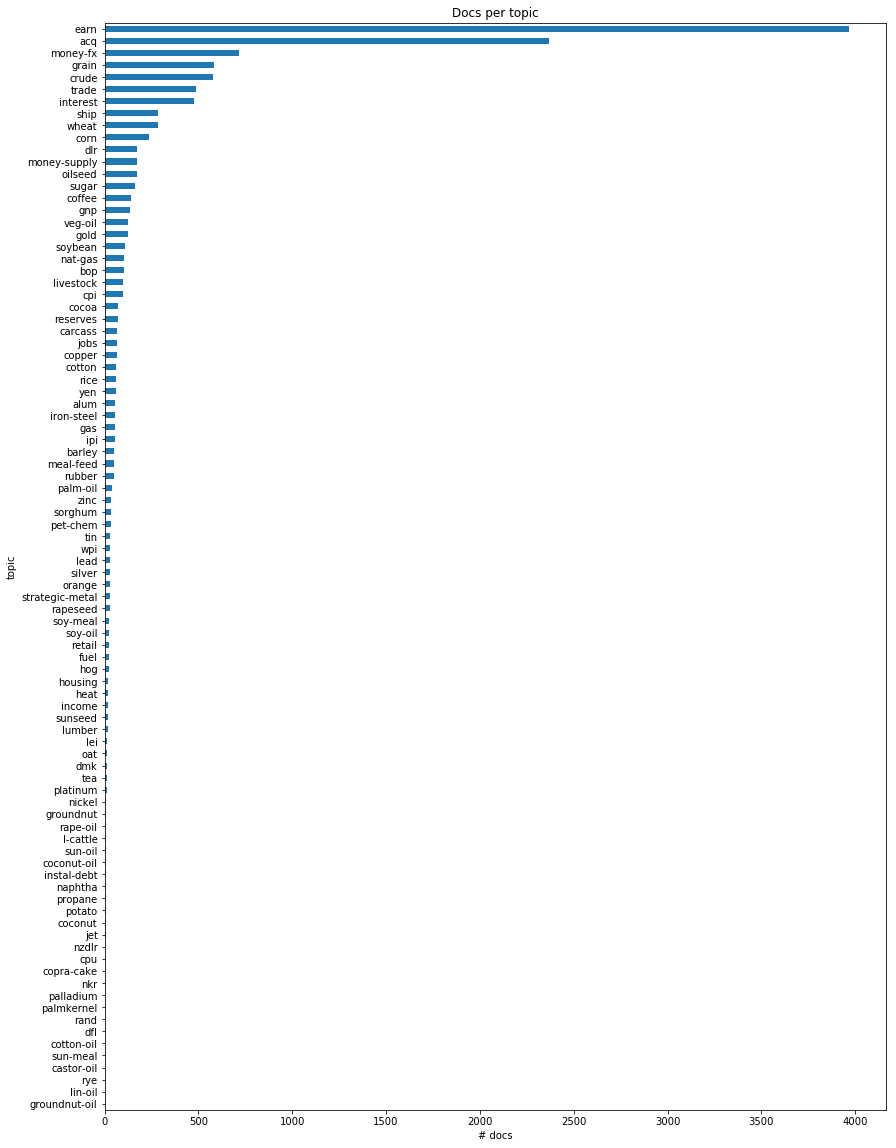

In [91]:
X, Y = dataset_helper.get_dataset('reuters-21578')
dataset_helper.plot_dataset_class_distribution(X, Y, figsize = (14, 20))
plt.show()

In [134]:
datasets = dataset_helper.get_all_datasets()